In [1]:
import tensorflow as tf
%load_ext tensorboard
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
import datetime
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statistics
!rm -rf ./logs/ 
print(tf.__version__) #Double check the colab has the instance of tensorflow we want

2.15.1


# Import the Dataset

In [2]:
lab_data = pd.read_csv('../data/83_Loeschcke_et_al_2000_Thorax_&_wing_traits_lab pops.csv')

# Data Cleaning

In [3]:
lab_data = pd.read_csv('../data/83_Loeschcke_et_al_2000_Thorax_&_wing_traits_lab pops.csv')

# Data cleaning
erroneous = lab_data[lab_data['Thorax_length'] == '.']
erroneous

,Species,Population,Latitude,Longitude,Year_start,Year_end,Temperature,Vial,Replicate,Sex,Thorax_length,l2,l3p,l3d,lpd,l3,w1,w2,w3,wing_loading
253,D._aldrichi,Gogango_Creek,-23.77,150.17,1994,1994,25,6,3,female,.,1.65,0.573,1.415,1.988,1.986,0.898,1.207,1.003,.


In [4]:
similar_rows = lab_data[
    (lab_data['Species'] == 'D._aldrichi')
    & (lab_data['Population'] == 'Gogango_Creek')
    & (lab_data['Sex'] == 'female')
    & (lab_data['Thorax_length'] != ".")
]
similar_rows['Thorax_length'] = pd.to_numeric(similar_rows['Thorax_length'])
similar_rows.head()

/var/folders/j_/9f1md2vd0_s6kpn12szf1t2c0000gn/T/ipykernel_1128/3776846164.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_rows['Thorax_length'] = pd.to_numeric(similar_rows['Thorax_length'])


,Species,Population,Latitude,Longitude,Year_start,Year_end,Temperature,Vial,Replicate,Sex,Thorax_length,l2,l3p,l3d,lpd,l3,w1,w2,w3,wing_loading
162,D._aldrichi,Gogango_Creek,-23.77,150.17,1994,1994,20,1,1,female,1.166,1.910,0.578,1.675,2.254,2.252,0.982,1.381,1.123,1.932
164,D._aldrichi,Gogango_Creek,-23.77,150.17,1994,1994,20,1,2,female,1.174,1.829,0.622,1.549,2.170,2.170,0.997,1.360,1.117,1.848
166,D._aldrichi,Gogango_Creek,-23.77,150.17,1994,1994,20,1,3,female,1.199,1.864,0.585,1.659,2.244,2.242,1.009,1.376,1.142,1.870
167,D._aldrichi,Gogango_Creek,-23.77,150.17,1994,1994,20,2,1,female,1.186,1.872,0.628,1.571,2.199,2.199,1.002,1.356,1.143,1.854
169,D._aldrichi,Gogango_Creek,-23.77,150.17,1994,1994,20,2,2,female,1.176,1.872,0.630,1.579,2.207,2.207,0.966,1.345,1.103,1.876


In [5]:
similar_row_median = similar_rows['Thorax_length'].median()

lab_data['Thorax_length'] = lab_data.apply(
    lambda x: (x['Thorax_length'] if x['Thorax_length'] != "." else similar_row_median),
    axis=1
)
lab_data.head()

lab_data['wing_loading'] = lab_data.apply(
    lambda x: (x['wing_loading'] if x['wing_loading'] != "." else round((x['l3'] / x['Thorax_length']), 3)),
    axis=1
)

print(len(similar_rows))
print(similar_row_median)

lab_data.loc[253]

87
1.141


Species            D._aldrichi
Population       Gogango_Creek
Latitude                -23.77
Longitude               150.17
Year_start                1994
Year_end                  1994
Temperature                 25
Vial                         6
Replicate                    3
Sex                     female
Thorax_length            1.141
l2                        1.65
l3p                      0.573
l3d                      1.415
lpd                      1.988
l3                       1.986
w1                       0.898
w2                       1.207
w3                       1.003
wing_loading             1.741
Name: 253, dtype: object

In [6]:
similar_row_median = similar_rows['Thorax_length'].median()

lab_data['Thorax_length'] = lab_data.apply(
    lambda x: (x['Thorax_length'] if x['Thorax_length'] != "." else similar_row_median),
    axis=1
)
lab_data.head()

lab_data['wing_loading'] = lab_data.apply(
    lambda x: (x['wing_loading'] if x['wing_loading'] != "." else round((x['l3'] / x['Thorax_length']), 3)),
    axis=1
)

print(len(similar_rows))
print(similar_row_median)

lab_data.loc[253]

87
1.141


Species            D._aldrichi
Population       Gogango_Creek
Latitude                -23.77
Longitude               150.17
Year_start                1994
Year_end                  1994
Temperature                 25
Vial                         6
Replicate                    3
Sex                     female
Thorax_length            1.141
l2                        1.65
l3p                      0.573
l3d                      1.415
lpd                      1.988
l3                       1.986
w1                       0.898
w2                       1.207
w3                       1.003
wing_loading             1.741
Name: 253, dtype: object

In [7]:
lab_data['Thorax_length'] = pd.to_numeric(lab_data['Thorax_length'])
lab_data['wing_loading'] = pd.to_numeric(lab_data['wing_loading'])

In [8]:
erroneous_2 = lab_data[(lab_data['l3d'] == 0) & (lab_data['l3p'] != 0)]
erroneous_2

,Species,Population,Latitude,Longitude,Year_start,Year_end,Temperature,Vial,Replicate,Sex,Thorax_length,l2,l3p,l3d,lpd,l3,w1,w2,w3,wing_loading
61,D._aldrichi,Binjour,-25.52,151.45,1994,1994,25,3,1,female,1.106,0.0,0.6,0.0,0.0,0.0,0.0,1.252,0.0,0.0


In [9]:
similar_rows_2 = lab_data[
    (lab_data['Species'] == 'D._aldrichi')
    & (lab_data['Population'] == 'Binjour')
    & (lab_data['Sex'] == 'female')
    & (lab_data['l3d'] != "0")
]

similar_rows_2_l2_median = similar_rows_2['l2'].median()
similar_rows_2_l3d_median = similar_rows_2['l3d'].median()
similar_rows_2_lpd_median = similar_rows_2['lpd'].median()
similar_rows_2_l3_median = similar_rows_2['l3'].median()
similar_rows_2_w1_median = similar_rows_2['w1'].median()
similar_rows_2_w3_median = similar_rows_2['w3'].median()
lab_data.loc[61, 'l2'] = similar_rows_2_l2_median
lab_data.loc[61, 'l3d'] = similar_rows_2_l3d_median
lab_data.loc[61, 'lpd'] = similar_rows_2_lpd_median
lab_data.loc[61, 'l3'] = similar_rows_2_l3_median
lab_data.loc[61, 'w1'] = similar_rows_2_w1_median
lab_data.loc[61, 'w3'] = similar_rows_2_w3_median
lab_data.loc[61, 'wing_loading'] = lab_data.loc[61]['l3'] / lab_data.loc[61]['Thorax_length']
lab_data.loc[[61]]

,Species,Population,Latitude,Longitude,Year_start,Year_end,Temperature,Vial,Replicate,Sex,Thorax_length,l2,l3p,l3d,lpd,l3,w1,w2,w3,wing_loading
61,D._aldrichi,Binjour,-25.52,151.45,1994,1994,25,3,1,female,1.106,1.799,0.6,1.5235,2.1195,2.1185,0.9235,1.252,1.0495,1.915461


In [10]:
erroneous_3 = lab_data[(lab_data['l3d'] == 0) & (lab_data['l3p'] == 0)]
erroneous_3

,Species,Population,Latitude,Longitude,Year_start,Year_end,Temperature,Vial,Replicate,Sex,Thorax_length,l2,l3p,l3d,lpd,l3,w1,w2,w3,wing_loading
698,D._aldrichi,Wahruna,-25.2,151.17,1994,1994,20,5,3,female,1.151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#TODO: 
similar_rows_3 = lab_data[
    (lab_data['Species'] == 'D._aldrichi')
    & (lab_data['Population'] == 'Wahruna')
    & (lab_data['Sex'] == 'female')
    & (lab_data['l3d'] != "0")
]
len(similar_rows_3)

84

In [12]:
similar_rows_3_l2_median = similar_rows_3['l2'].median()
similar_rows_3_l3p_median = similar_rows_3['l3p'].median()
similar_rows_3_l3d_median = similar_rows_3['l3d'].median()
similar_rows_3_lpd_median = similar_rows_3['lpd'].median()
similar_rows_3_l3_median = similar_rows_3['l3'].median()
similar_rows_3_w1_median = similar_rows_3['w1'].median()
similar_rows_3_w2_median = similar_rows_3['w2'].median()
similar_rows_3_w3_median = similar_rows_3['w3'].median()


lab_data.loc[698, 'l2'] = similar_rows_3_l2_median
lab_data.loc[698, 'l3p'] = similar_rows_3_l3p_median
lab_data.loc[698, 'l3d'] = similar_rows_3_l3d_median
lab_data.loc[698, 'lpd'] = similar_rows_3_lpd_median
lab_data.loc[698, 'l3'] = similar_rows_3_l3_median
lab_data.loc[698, 'w1'] = similar_rows_3_w1_median
lab_data.loc[698, 'w2'] = similar_rows_3_w2_median
lab_data.loc[698, 'w3'] = similar_rows_3_w3_median
lab_data.loc[698, 'wing_loading'] = lab_data.loc[698]['l3'] / lab_data.loc[698]['Thorax_length']

lab_data.loc[[698]]

,Species,Population,Latitude,Longitude,Year_start,Year_end,Temperature,Vial,Replicate,Sex,Thorax_length,l2,l3p,l3d,lpd,l3,w1,w2,w3,wing_loading
698,D._aldrichi,Wahruna,-25.2,151.17,1994,1994,20,5,3,female,1.151,1.7405,0.6,1.4925,2.0855,2.084,0.943,1.2805,1.0645,1.810599


In [13]:
lab_data['Thorax_length'] = pd.to_numeric(lab_data['Thorax_length'])
lab_data['wing_loading'] = pd.to_numeric(lab_data['wing_loading'])

In [14]:
lab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1731 entries, 0 to 1730
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Species        1731 non-null   object 
 1   Population     1731 non-null   object 
 2   Latitude       1731 non-null   float64
 3   Longitude      1731 non-null   float64
 4   Year_start     1731 non-null   int64  
 5   Year_end       1731 non-null   int64  
 6   Temperature    1731 non-null   int64  
 7   Vial           1731 non-null   int64  
 8   Replicate      1731 non-null   int64  
 9   Sex            1731 non-null   object 
 10  Thorax_length  1731 non-null   float64
 11  l2             1731 non-null   float64
 12  l3p            1731 non-null   float64
 13  l3d            1731 non-null   float64
 14  lpd            1731 non-null   float64
 15  l3             1731 non-null   float64
 16  w1             1731 non-null   float64
 17  w2             1731 non-null   float64
 18  w3      

# SPECIES

In [15]:
print('Wing Length (L3)')
print('Mean')
print(lab_data.groupby(['Species'])['l3'].mean())
print('Std. Dev')
print(lab_data.groupby(['Species'])['l3'].std())

Wing Length (L3)
Mean
Species
D._aldrichi    2.014441
D._buzzatii    2.069377
Name: l3, dtype: float64
Std. Dev
Species
D._aldrichi    0.166895
D._buzzatii    0.157329
Name: l3, dtype: float64


In [16]:
print('Wing Width (W3)')
print('Mean')
print(lab_data.groupby(['Species'])['w3'].mean())
print('Std. Dev')
print(lab_data.groupby(['Species'])['w3'].std())

Wing Width (W3)
Mean
Species
D._aldrichi    1.033436
D._buzzatii    1.045218
Name: w3, dtype: float64
Std. Dev
Species
D._aldrichi    0.085588
D._buzzatii    0.078934
Name: w3, dtype: float64


In [17]:
print('Thorax Length:')
print('Mean')
print(lab_data.groupby(['Species'])['Thorax_length'].mean())
print('Std. Dev')
print(lab_data.groupby(['Species'])['Thorax_length'].std())

Thorax Length:
Mean
Species
D._aldrichi    1.115644
D._buzzatii    1.136756
Name: Thorax_length, dtype: float64
Std. Dev
Species
D._aldrichi    0.063513
D._buzzatii    0.065885
Name: Thorax_length, dtype: float64


<Axes: xlabel='Population', ylabel='Thorax_length'>

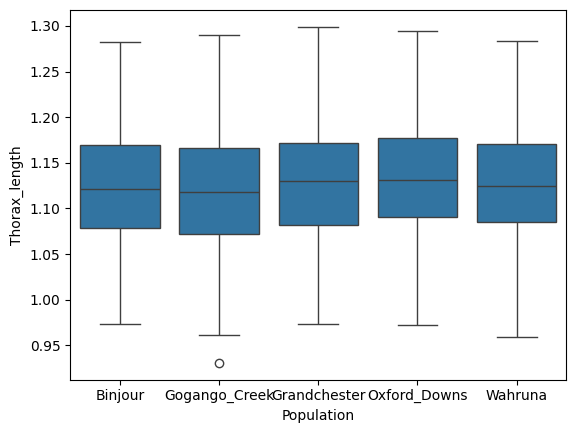

In [22]:
sns.boxplot(x='Population', y=lab_data['Thorax_length'], data=lab_data)

<Axes: xlabel='Species', ylabel='Thorax_length'>

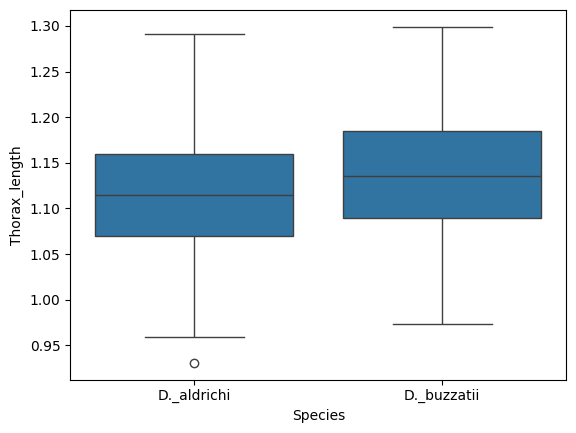

In [23]:
sns.boxplot(x='Species', y=lab_data['Thorax_length'], data=lab_data)

<Axes: xlabel='Sex', ylabel='Thorax_length'>

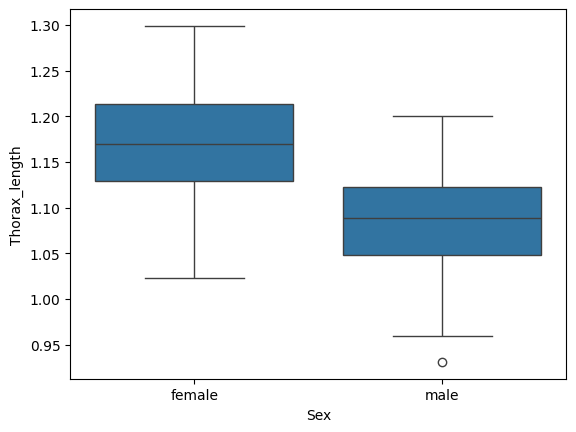

In [24]:
sns.boxplot(x='Sex', y=lab_data['Thorax_length'], data=lab_data)

# Sex Distributions

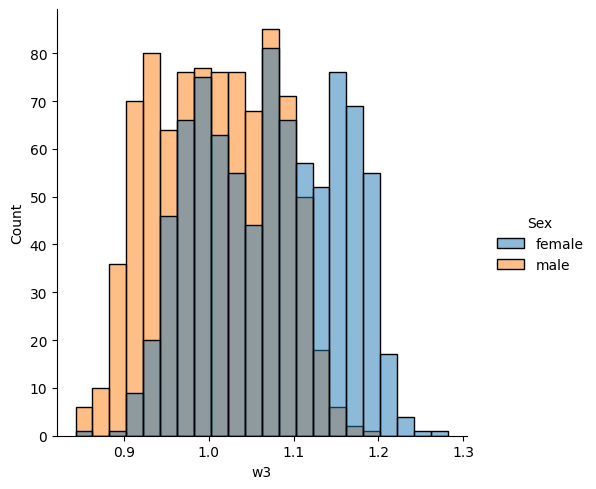

In [30]:
sns.displot(lab_data, x="w3", hue = "Sex")

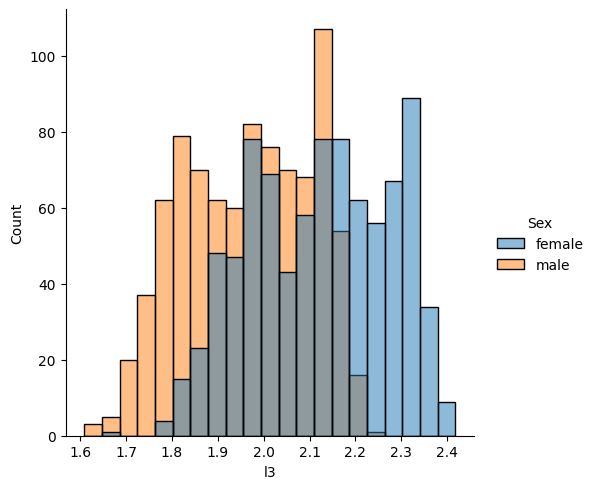

In [31]:
sns.displot(lab_data, x="l3", hue = "Sex")

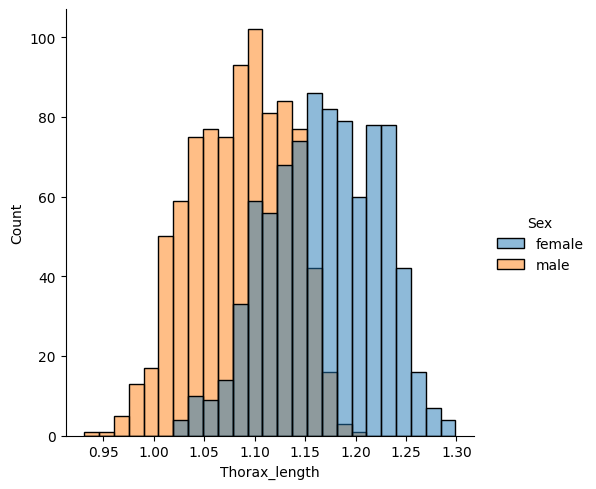

In [32]:
sns.displot(lab_data, x="Thorax_length", hue = "Sex")

# Species Distributions

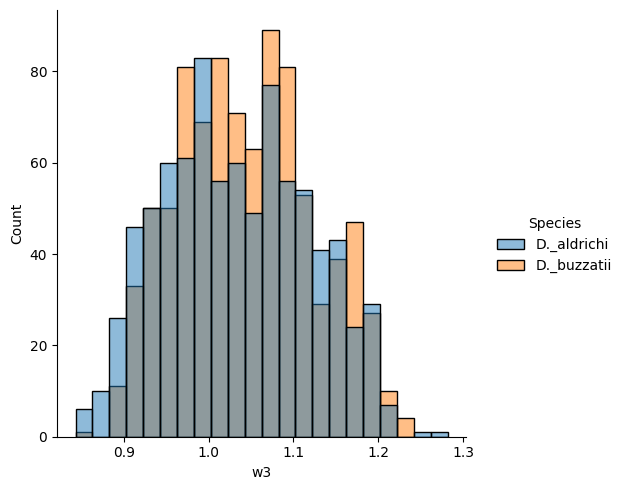

In [33]:
sns.displot(lab_data, x="w3", hue = "Species")

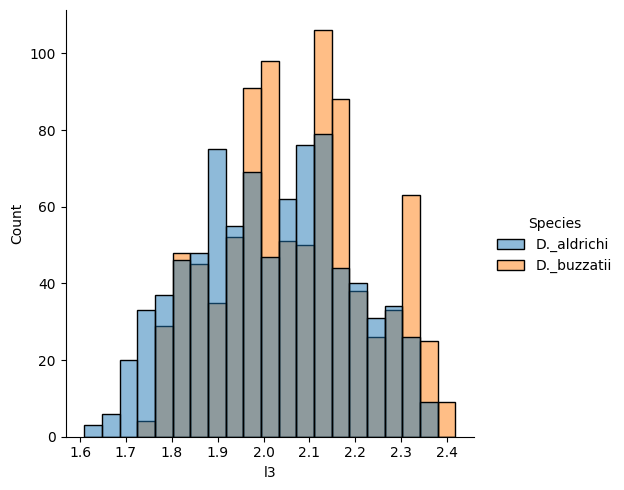

In [34]:
sns.displot(lab_data, x="l3", hue = "Species")

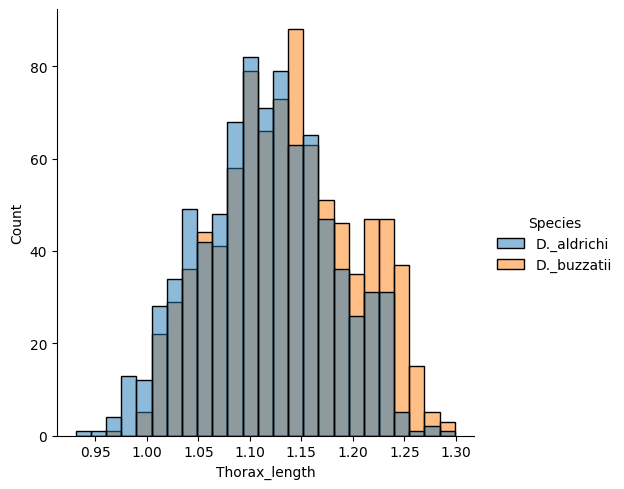

In [35]:
sns.displot(lab_data, x="Thorax_length", hue = "Species")

# Population Distributions

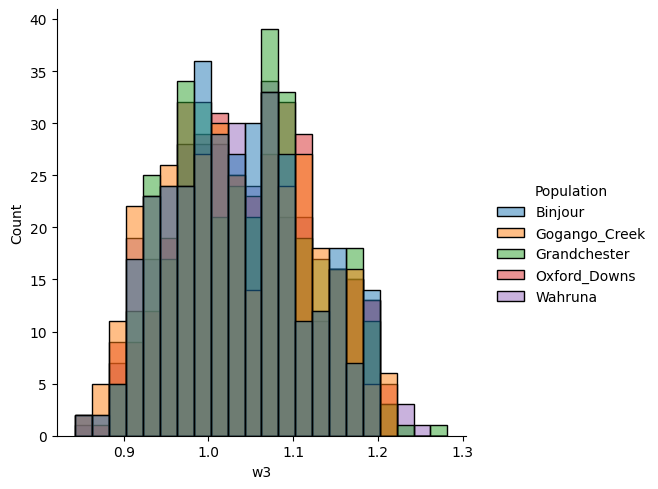

In [36]:
sns.displot(lab_data, x="w3", hue = "Population")

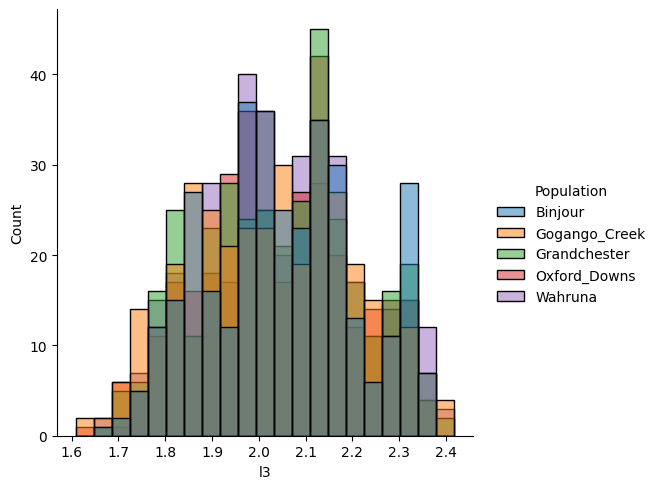

In [37]:
sns.displot(lab_data, x="l3", hue = "Population")

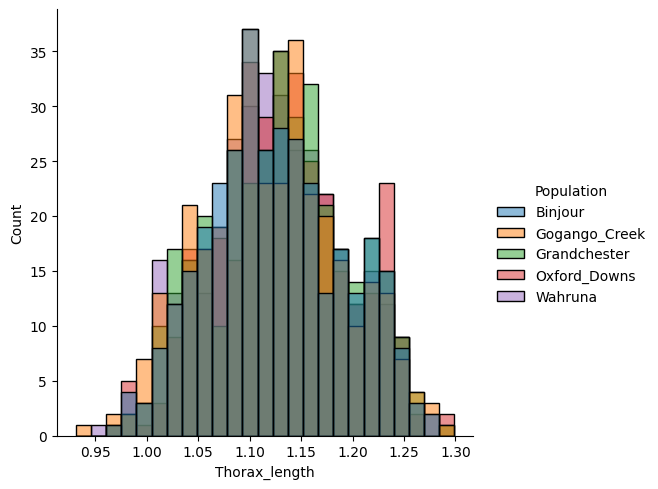

In [38]:
sns.displot(lab_data, x="Thorax_length", hue = "Population")

# Sex

In [16]:
print('Wing Length (L3)')
print('Mean')
print(lab_data.groupby(['Sex'])['l3'].mean())
print('Std. Dev')
print(lab_data.groupby(['Sex'])['l3'].std())

Wing Length (L3)
Mean
Sex
female    2.116971
male      1.964904
Name: l3, dtype: float64
Std. Dev
Sex
female    0.183027
male      0.136882
Name: l3, dtype: float64


In [17]:
print('Wing Width (W3)')
print('Mean')
print(lab_data.groupby(['Sex'])['w3'].mean())
print('Std. Dev')
print(lab_data.groupby(['Sex'])['w3'].std())

Wing Width (W3)
Mean
Sex
female    1.070476
male      1.006640
Name: w3, dtype: float64
Std. Dev
Sex
female    0.096003
male      0.069827
Name: w3, dtype: float64


In [18]:
print('Thorax Length:')
print('Mean')
print(lab_data.groupby(['Sex'])['Thorax_length'].mean())
print('Std. Dev')
print(lab_data.groupby(['Sex'])['Thorax_length'].std())

Thorax Length:
Mean
Sex
female    1.168465
male      1.085214
Name: Thorax_length, dtype: float64
Std. Dev
Sex
female    0.053671
male      0.047610
Name: Thorax_length, dtype: float64


<Axes: xlabel='Sex', ylabel='Thorax_length'>

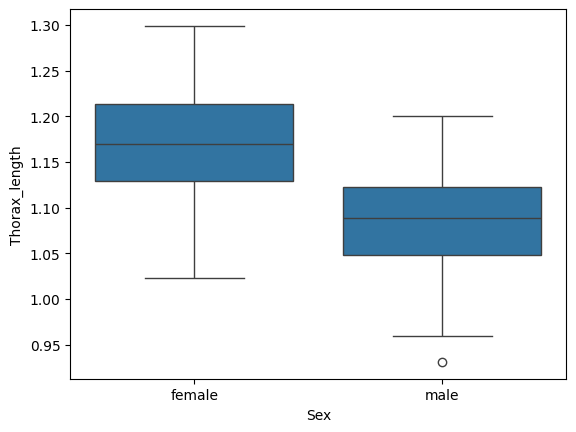

In [25]:
sns.boxplot(x='Sex', y=lab_data['Thorax_length'], data=lab_data)

# Population

In [19]:
print('Wing Length (L3)')
print('Mean')
print(lab_data.groupby(['Population'])['l3'].mean())
print('Std. Dev')
print(lab_data.groupby(['Population'])['l3'].std())

Wing Length (L3)
Mean
Population
Binjour          2.045850
Gogango_Creek    2.028960
Grandchester     2.043688
Oxford_Downs     2.039575
Wahruna          2.043806
Name: l3, dtype: float64
Std. Dev
Population
Binjour          0.195162
Gogango_Creek    0.173376
Grandchester     0.165062
Oxford_Downs     0.156167
Wahruna          0.198986
Name: l3, dtype: float64


In [20]:
print('Wing Width (W3)')
print('Mean')
print(lab_data.groupby(['Population'])['w3'].mean())
print('Std. Dev')
print(lab_data.groupby(['Population'])['w3'].std())

Wing Width (W3)
Mean
Population
Binjour          1.029323
Gogango_Creek    1.033640
Grandchester     1.046158
Oxford_Downs     1.046132
Wahruna          1.036254
Name: w3, dtype: float64
Std. Dev
Population
Binjour          0.096372
Gogango_Creek    0.085721
Grandchester     0.081626
Oxford_Downs     0.080932
Wahruna          0.101278
Name: w3, dtype: float64


In [21]:
print('Thorax Length:')
print('Mean')
print(lab_data.groupby(['Population'])['Thorax_length'].mean())
print('Std. Dev')
print(lab_data.groupby(['Population'])['Thorax_length'].std())

Thorax Length:
Mean
Population
Binjour          1.124818
Gogango_Creek    1.120669
Grandchester     1.129014
Oxford_Downs     1.132443
Wahruna          1.125728
Name: Thorax_length, dtype: float64
Std. Dev
Population
Binjour          0.065749
Gogango_Creek    0.067855
Grandchester     0.065537
Oxford_Downs     0.064142
Wahruna          0.064355
Name: Thorax_length, dtype: float64


<Axes: xlabel='Population', ylabel='Thorax_length'>

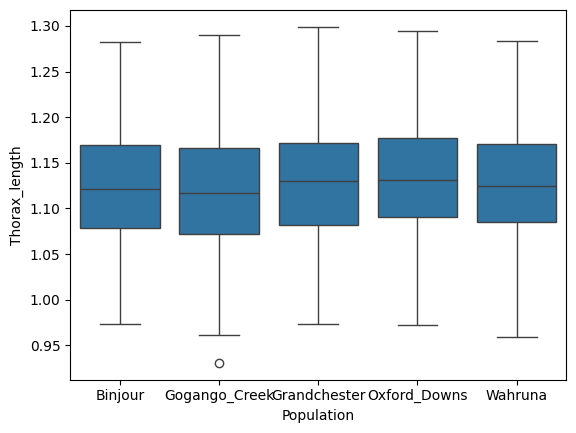

In [24]:
sns.boxplot(x='Population', y=lab_data['Thorax_length'], data=lab_data)